### Rnnlm으로 문장 생성해보기

Rnnlm에 첫 단어 'you'를 입력한 후, 'you' 다음으로 올 단어의 확률분포에 따라 단어를 무작위로 1개를 선정한다. 이후, 선정된 단어를 다시 Rnnlm에 입력하여, 단어를 연달아 생성하면 하나의 문장이 만들어진다. 저번 챕터에서 학습한 가중치로 문장을 만들어보자. 여기에서는 BetterRnnlm()으로 문장을 만들어보았다.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

class RnnlmGen(BetterRnnlm):
  def generate(self, start_id, skip_ids=None, sample_size=100):
    word_ids = [start_id]

    x = start_id
    while len(word_ids) < sample_size:
      x = np.array(x).reshape(1, 1)
      score = self.predict(x)
      p = softmax(score.flatten())

      sampled = np.random.choice(len(p), size=1, p=p)
      if (skip_ids is None) or (sampled not in skip_ids):
        x = sampled
        word_ids.append(int(x))

    return word_ids

corpus, word_to_id, id_to_word = load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('/content/BetterRnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you did n't have a hard time to get called.
 the big board has asked the standard to keep economic plans with the ministry reported this year.
 the new york times 's new package had net of junk 's and less than a year faced with hooker 's maximize dividend results.
 the treasury also said it will raise cash and have paid their assets to finance the board of his international merchant banking and kidder has purchased hotels at datapoint corp. over three years.
 gonzalez toilet co. a junior claimed minerals concern based in canada launched


### seq2seq 모델

seq2seq는 2개의 RNN으로 이루어진 신경망으로, 시계열을 다른 시계열로 변환해주는 신경망이다. Encoder - Decoder 모델이라고도 한다.

Encoder는 입력된 시계열 데이터를 벡터로 변환시키면서, 번역에 필요한 정보를 조밀하게 응축한다. Decoder는 이 응축된 정보를 활용하여 출력용 시계열 데이터를 생성한다.

Encoder에 입력되는 시계열 데이터는 보통 가변 길이인 경우가 많은데, 학습을 시킬때는 길이가 일정해야 하므로, 길이를 맞추어 주는 '패딩'을 사용한다.

In [ ]:
# Encoder 클래스
class Encoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size

    embed_W = (np.random.randn(V, D) / 100).astype(np.float32)
    lstm_Wx = (np.random.randn(D, 4*H) / np.sqrt(D)).astype(np.float32)
    lstm_Wh = (np.random.randn(H, 4*H) / np.sqrt(H)).astype(np.float32)
    lstm_b = np.zeros(4*H).astype(np.float32)

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

    self.params = self.embed.params + self.lstm.params
    self.grads = self.embed.grads + self.lstm.grads
    self.hs = None

  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    self.hs = hs
    return hs[:, -1, :]

  def backward(self, dh):
    dhs = np.zeros_like(self.hs)
    dhs[:, -1, :] = dh

    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout

Decoder 클래스는 Encoder 클래스가 출력한 h를 받아 목적으로 하는 다른 문자열을 출력한다. RNN으로 문장을 생성할 때, 학습 시와, 생성 시의 데이터 부여 방법이 다르다, 학습시는 정답을 알 고 있기 때문에 시계열 방향의 데이터를 한꺼번에 줄 수 있다. 한편, 추론시에는 최초 시작을 알리는 구분 문자(예를 들어 '_') 하나만 준다. 그리고 그 출력으로부터 문자를 하나 샘플링하여, 그 샘플링한 문자를 다음 입력으로 사용하는 과정을 반복한다.

In [ ]:
class Decoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size

    embed_W = (np.random.randn(V, D) / 100).astype(np.float32)
    lstm_Wx = (np.random.randn(D, 4*H) / np.sqrt(D)).astype(np.float32)
    lstm_Wh = (np.random.randn(H, 4*H) / np.sqrt(H)).astype(np.float32)
    lstm_b = np.zeros(4*H).astype(np.float32)
    affine_W = (np.random.randn(H, V) / np.sqrt(H)).astype(np.float32)
    affine_b = np.zeros(V).astype(np.float32)

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.affine = TimeAffine(affine_W, affine_b)

    self.params, self.grads = [], []
    for layer in (self.embed, self.lstm, self.affine):
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, h):
    self.lstm.set_state(h)

    out = self.embed.forward(xs)
    out = self.lstm.forward(out)
    score = self.affine.forward(out)
    return score

  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    dout = self.lstm.backward(dout)
    dout = self.embed.backward(dout)
    dh = self.lstm.dh
    return dh

  # 추론시 문장 생성을 담당하는 함수
  def generate(self, h, start_id, sample_size):
    sampled = []
    sample_id = start_id
    self.lstm.set_state(h)

    for _ in range(sample_size):
      x = np.array(sample_id).reshape((1, 1))
      out = self.embed.forward(x)
      out = self.lstm.forward(out)
      score = self.affine.forward(out)

      sample_id = np.argmax(score.flatten())
      sampled.append(int(sample_id))

    return sampled

위에서 구현한 Encoder와 Decoder를 사용해서 Seq2Seq 클래스를 구현해보자.

In [19]:
class Seq2seq(BaseModel):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    self.encoder = Encoder(V, D, H)
    self.decoder = Decoder(V, D, H)
    self.softmax = TimeSoftmaxWithLoss()

    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

  def forward(self, xs, ts):
    decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
    h = self.encoder.forward(xs)
    score = self.decoder.forward(decoder_xs, h)
    loss = self.softmax.forward(score, decoder_ts)
    return loss

  def backward(self, dout=1):
    dout = self.softmax.backward(dout)
    dh = self.decoder.backward(dout)
    dout = self.encoder.backward(dh)
    return dout

  def generate(self, xs, start_id, sample_size):
    h = self.encoder.forward(xs)
    sampled = self.decoder.generate(h, start_id, sample_size)
    return sampled

seq2seq를 학습시키기 위한 코드를 작성한다.

| 에폭 1 | 시간 15[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---
Q 26+838 
T 864 
☒ 1000
---
Q 143+93 
T 236 
☒ 100 
---
검증 정확도   0%
| 에폭 2 | 시간 15[s] | 손실 1.67
Q 77+85  
T 162 
☒ 994 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 700 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 400 
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1544
---
Q 26+838 
T 864 
☒ 400 
---
Q 143+93 
T 236 
☒ 400 
---
검증 정확도   0%
| 에폭 3 | 시간 16[s] | 손실 1.48
Q 77+85  
T 162 
☒ 108 
---
Q 975+164
T 1139
☒ 1001
---
Q 582+84 
T 666 
☒ 648 
---
Q 8+155  
T 163 
☒ 138 
---
Q 367+55 
T 422 
☒ 448 
---
Q 600+257
T 857 
☒ 848 
---
Q 761+292
T 1053
☒ 1011
---
Q 830+597
T 1427
☒ 1373
---
Q 26+838 
T 864 
☒ 868 
---
Q 143+93 
T 236 
☒ 348 
---
검증 정확도   1%
| 에폭 4 | 시간 16[s] | 손실 1.30
Q 77+85  
T 

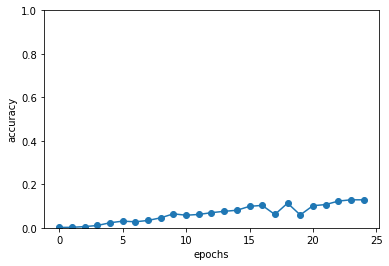

In [ ]:
import matplotlib.pyplot as plt

# 데이터 읽기 
# (https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/dataset/addition.txt)
(x_train, t_train), (x_test, t_test) = load_data('addition.txt')
char_to_id, id_to_char = get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)

  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)
  print('검증 정확도 %3.f%%' % (acc * 100))

plt.plot(range(max_epoch), acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

### **seq2seq 개선하기**

이번에는 앞 코드의 seq2seq를 세분화하여 학습 속도를 개선해보고자 한다.

#### **1. 입력 데이터 반전**

첫 번째 개선안은 입력 데이터를 반전시키는 것이다. 이 트릭을 사용하면 많은 경우 학습 진행이 빨라져서, 결과적으로 최종 정확도도 좋아진다고 한다.

#### **2. 엿보기(Peeky)**

앞의 Encoder는 입력 문장을 고정 길이 벡터 h로 변환한다. 이때, h 안에는 Decoder에게 필요한 정보가 모두 담겨 있다. 즉, h가 Decoder에 있어서는 유일한 정보인 셈이다. 그러나 현재의 seq2seq는 최초 시각의 LSTM 계층만이 벡터 h를 이용하고 있다.

바로 이지점에서 seq2seq의 두번째 개선안이 등장하는데, 중요한 정보가 담긴 Encoder의 출력 h를 Decoder의 다른 계층에게도 전해주는 것이다.

In [39]:
import numpy as np

class PeekyDecoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(H + D, 4*H) / np.sqrt(H + D)).astype('f')
    lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.affine = TimeAffine(affine_W, affine_b)

    self.params, self.grads = [], []
    for layer in (self.embed, self.lstm, self.affine):
      self.params += layer.params
      self.grads += layer.grads
    self.cache = None

  def forward(self, xs, h):
    N, T = xs.shape
    N, H = h.shape

    self.lstm.set_state(h)

    out = self.embed.forward(xs)
    hs = np.repeat(h, T, axis=0).reshape(N, T, H)
    out = np.concatenate((hs, out), axis=2)

    out = self.lstm.forward(out)
    out = np.concatenate((hs, out), axis=2)

    score = self.affine.forward(out)
    self.cache = H
    return score

  def backward(self, dscore):
    H = self.cache
    dout = self.affine.backward(dscore)
    dout, dhs0 = dout[:, :, H:], dout[:, :, :H], 
    dout = self.lstm.backward(dout)
    dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
    self.embed.backward(dembed)

    dh = self.lstm.dh + np.sum(dhs0 + dhs1, axis=1)
    return dh

  # 추론시 문장 생성을 담당하는 함수
  def generate(self, h, start_id, sample_size):
    sampled = []
    sample_id = start_id
    self.lstm.set_state(h)

    H = h.shape[1]
    peeky_h = h.reshape(1, 1, H)

    for _ in range(sample_size):
      x = np.array([sample_id]).reshape((1, 1))
      out = self.embed.forward(x)

      out = np.concatenate((peeky_h, out), axis=2)
      out = self.lstm.forward(out)
      out = np.concatenate((peeky_h, out), axis=2)
      score = self.affine.forward(out)

      sample_id = np.argmax(score.flatten())
      sampled.append(int(sample_id))

    return sampled

앞에서 구현한 PeekyDecoder를 사용해서 PeekySeq2seq를 구현해보기로 하자.

In [29]:
class PeekySeq2seq(Seq2seq):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    self.encoder = Encoder(V, D, H)
    self.decoder = PeekyDecoder(V, D, H)
    self.softmax = TimeSoftmaxWithLoss()

    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

학습하는 코드를 작성한다.

| 에폭 1 | 시간 23[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 582+84 
T 666 
☒ 102 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1023
---
Q 600+257
T 857 
☒ 1023
---
Q 761+292
T 1053
☒ 1023
---
Q 830+597
T 1427
☒ 1111
---
Q 26+838 
T 864 
☒ 102 
---
Q 143+93 
T 236 
☒ 102 
---
검증 정확도   0%
| 에폭 2 | 시간 25[s] | 손실 1.60
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1200
---
Q 582+84 
T 666 
☒ 690 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 690 
---
Q 600+257
T 857 
☒ 999 
---
Q 761+292
T 1053
☒ 1029
---
Q 830+597
T 1427
☒ 1240
---
Q 26+838 
T 864 
☒ 792 
---
Q 143+93 
T 236 
☒ 290 
---
검증 정확도   0%
| 에폭 3 | 시간 25[s] | 손실 1.35
Q 77+85  
T 162 
☒ 154 
---
Q 975+164
T 1139
☒ 1033
---
Q 582+84 
T 666 
☒ 644 
---
Q 8+155  
T 163 
☒ 161 
---
Q 367+55 
T 422 
☒ 433 
---
Q 600+257
T 857 
☒ 818 
---
Q 761+292
T 1053
☒ 1018
---
Q 830+597
T 1427
☒ 1344
---
Q 26+838 
T 864 
☒ 834 
---
Q 143+93 
T 236 
☒ 211 
---
검증 정확도   2%
| 에폭 4 | 시간 25[s] | 손실 1.10
Q 77+85  
T 

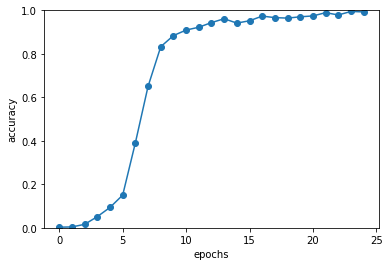

In [42]:
import matplotlib.pyplot as plt

# 데이터 읽기 
# (https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/dataset/addition.txt)
(x_train, t_train), (x_test, t_test) = load_data('addition.txt')
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1] # reverse
is_reverse = True

char_to_id, id_to_char = get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)

  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse)

  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)
  print('검증 정확도 %3.f%%' % (acc * 100))

plt.plot(range(max_epoch), acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()